In [1]:
#from src.io_utils import load_data, coerce_numeric 

#df = coerce_numeric(load_data("data/health_study_dataset.csv"))

#df.info()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/health_study_dataset.csv")

Räkna ut medel, median, min, max för:
- age
- weight
- height
- systolic_bp
- cholesterol

In [ ]:
# Calculates a summary of statistics for age, weight, height, systolic_bp, cholesterol

stats= df[["age", "weight", "height", "systolic_bp", "cholesterol"]].agg(["mean", "median", "min", "max"])
stats_summary = stats.rename(
    columns= {
    "age": "Age (years)",
    "weight": "Weight (kg)",
    "height": "Height (cm)", 
    "systolic_bp": "Systolic Blood Pressure (mmHg)",
    "cholesterol": "Cholesterol (mmol(L)"
})
stats_summary.round(1)


,Age (years),Weight (kg),Height (cm),Systolic Blood Pressure (mmHg),Cholesterol (mmol(L)
mean,49.4,73.4,171.8,149.2,4.9
median,50.0,73.2,171.4,149.4,5.0
min,18.0,33.7,144.4,106.8,2.5
max,90.0,114.4,200.4,185.9,7.9


Skapa minst 3 olika grafer!!!

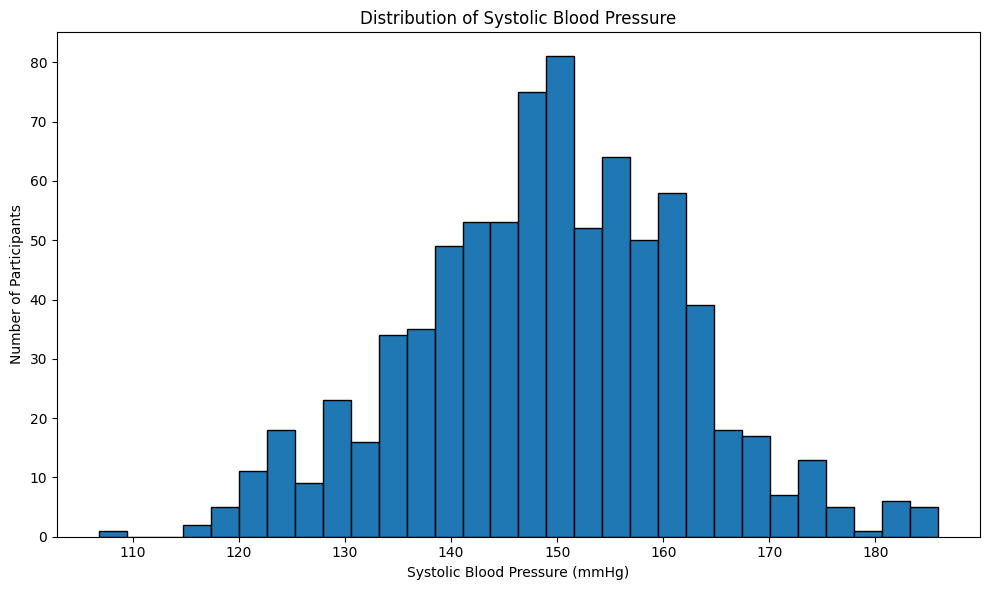

In [ ]:
# Histogram of systolic blood pressure
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(df["systolic_bp"], bins = 30, edgecolor= "black")
ax.set_title("Distribution of Systolic Blood Pressure")
ax.set_xlabel("Systolic Blood Pressure (mmHg)")
ax.set_ylabel("Number of Participants")
plt.tight_layout()


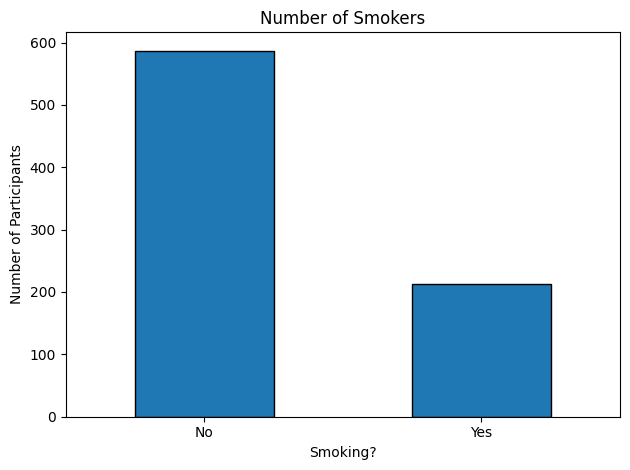

In [ ]:
# Bar plot of smokers vs non-smokers

total_smokers = df["smoker"].value_counts()
total_smokers.plot(kind="bar", edgecolor= "black")
plt.xlabel("Smoking?")
plt.xticks(rotation=0)
plt.ylabel("Number of Participants")
plt.title("Number of Smokers")
plt.tight_layout()

- Beräkna andel personer som har sjukdomen
- numpy för att aimulera 1000 slumpartade personer m samma sannolikhet för sjukdom
- Jämför simulerade andelen m verkliga andelen i dataset


Beräkna konfidensintervall för medelvärdet av systolic_bp (ex normalapproximation/bootstrap)

Testa hypotesen: "Rökare har högre medel-blodtryck än icke-rökare"
- Använd metod eg. bootstrap/t-test funktion
- Förklara kort resultatet i markdown!!

Förklaring av resultatet här: